<a href="https://colab.research.google.com/github/eduviana1/TEEP_Chuva_Horaria/blob/main/(Edu)_TEEP_chuva_horaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Trabalho Prático - Alerta Rio
Boxplot da chuva horária (de 01h até 24h) <br>
Considerado evento de chuva: Aquele em que a precipitação durar no mínimo 12h. Obs.: Mais de seis horas seguidas  sem registro de chuva, considera-se com término do evento. <br>
Identificar os eventos de chuvas en todas as estações. <br>
Evento de chuva de interesse: Aquele que acontecer em mais de 1/6 das estações. <br>



In [4]:
from google.colab import drive
drive.mount('/content/drive')
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from warnings import filterwarnings as fw
import datetime as dt
fw('ignore')

Mounted at /content/drive


In [5]:
diretorio = '/content/drive/MyDrive/Dados Alerta Rio/alerta_rio_csv'

arquivos_estacoes = glob.glob(diretorio + '/*.csv')

df_estacoes = pd.DataFrame(index = pd.date_range('1997-01-01', '2025-01-01', freq = 'H'),
                           columns = [os.path.basename(arquivo).removesuffix('.csv') for arquivo in arquivos_estacoes])
# Retirando a linha com a ultima data (2025-01-01)
df_estacoes.drop(df_estacoes.tail(1).index, inplace = True)

for arquivo in arquivos_estacoes:
  estacao = os.path.basename(arquivo).removesuffix('.csv')
  df = pd.read_csv(arquivo)
  df_horario =  df.loc[df['Hora'].str.endswith(':00:00')]
  df_horario['DataHora'] = pd.to_datetime(df_horario['Dia'] + ' ' + df_horario['Hora'], format = '%d/%m/%Y %H:%M:%S')
  df_horario.set_index('DataHora', inplace = True)
  df_estacoes.loc[df_horario.index, estacao] = df_horario['01 h'].astype('float')


df_estacoes.drop(df_estacoes.head(1).index, inplace = True)
df_estacoes = df_estacoes.reset_index(names = 'DataHora')
df_estacoes.drop(columns = ['DataHora']).astype('float')
df_estacoes['Hora'] = df_estacoes['DataHora'].dt.hour
df_estacoes.to_csv('chuva_horaria_alertario.csv', index = False)

In [6]:
df_estacoes.head()

,DataHora,alto_da_boa_vista,anchieta,av_brasil_mendanha,bangu,barrinha,campo_grande,cidade_de_deus,copacabana,grajau,...,santa_teresa,sao_cristovao,saude,sepetiba,tanque,tijuca,tijuca_muda,urca,vidigal,Hora
0,1997-01-01 01:00:00,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,1
1,1997-01-01 02:00:00,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,2
2,1997-01-01 03:00:00,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,3
3,1997-01-01 04:00:00,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,4
4,1997-01-01 05:00:00,NaN,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.0,5


# Graficos Boxplot

Text(0.5, 1.0, 'Boxplot da Distribuição da Chuva por Hora')

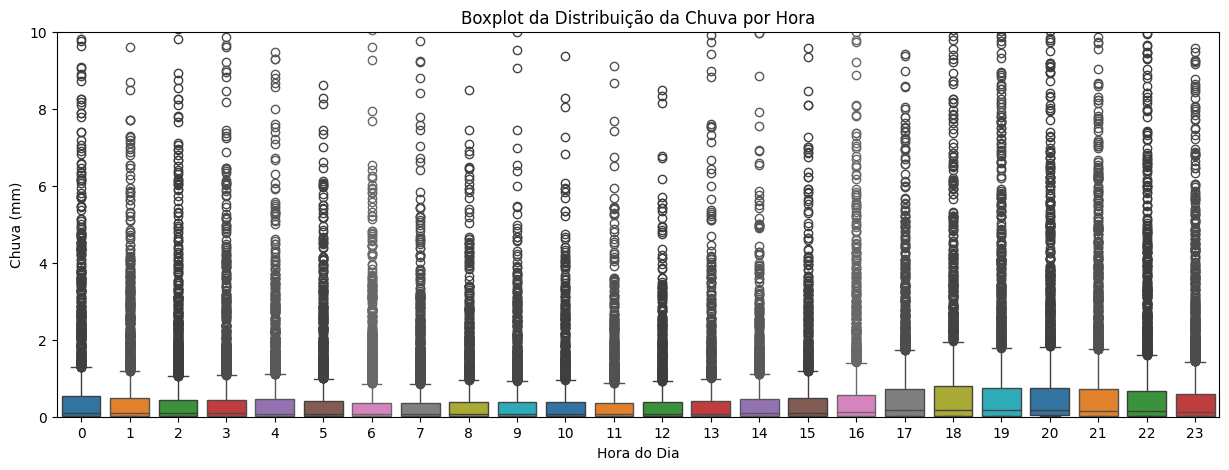

In [7]:
# Boxplot distribuição horária
fig, ax = plt.subplots(1,1, figsize = (15,5))

for hora in range(0,24):
  # Tirando a média dos valores das estações para um mesmo horario
  df_hora = (df_estacoes[(df_estacoes["Hora"] == hora)]
             .drop(columns = ['DataHora', 'Hora'])
             .mean(axis = 1) )
  # Filtrando valores acima de 0.0
  df_hora = df_hora[df_hora > 0.0]
  # Plotando Boxplot
  sns.boxplot(y = df_hora, x = hora, ax = ax)

# Ajustando limite vertical do grafico (até y = 10)
ax.set_ylim(0,10)
# Adicionando Titulo e legendas
ax.set_xlabel('Hora do Dia')
ax.set_ylabel('Chuva (mm)')
ax.set_title('Boxplot da Distribuição da Chuva por Hora')

Text(0.5, 1.0, 'Boxplot da Distribuição da Chuva por Hora')

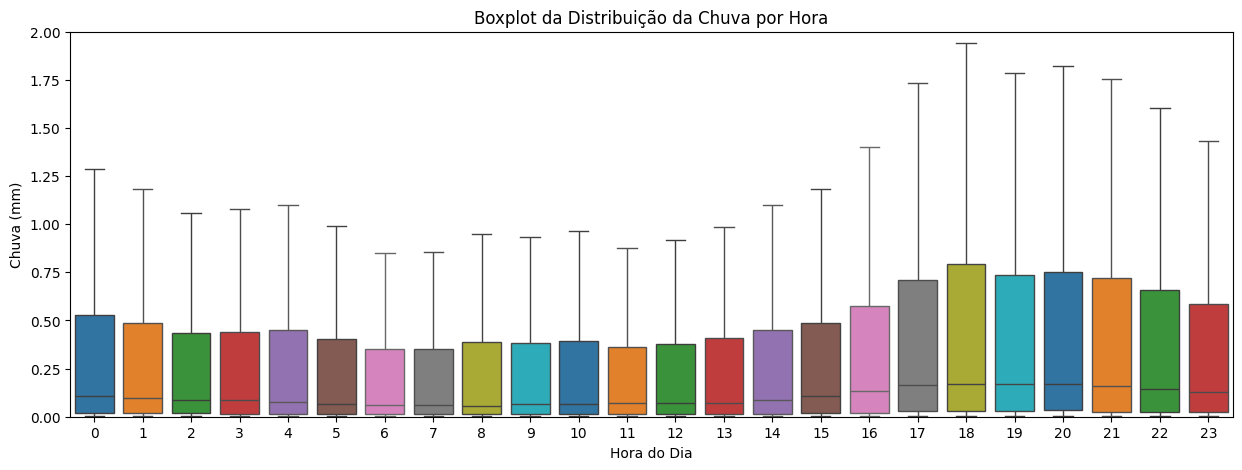

In [8]:
# Boxplot sem outliers
fig, ax = plt.subplots(1,1, figsize = (15,5))

for hora in range(0,24):
  # Tirando a média dos valores das estações para um mesmo horario
  df_hora = (df_estacoes[(df_estacoes["Hora"] == hora)]
             .drop(columns = ['DataHora', 'Hora'])
             .mean(axis = 1) )
  # Filtrando valores acima de 0.0
  df_hora = df_hora[df_hora > 0.0]
  # Plotando Boxplot (sem marcadores de outlier)
  sns.boxplot(y = df_hora, x = hora, ax = ax, showfliers = False)

# Ajustando limite vertical do grafico (até y = 10)
ax.set_ylim(0,2)
# Adicionando Titulo e legendas
ax.set_xlabel('Hora do Dia')
ax.set_ylabel('Chuva (mm)')
ax.set_title('Boxplot da Distribuição da Chuva por Hora')

# Detectando eventos de chuva

In [9]:
# Evento de chuva: Aquele em que a precipitação durar no mínimo 12h.
# Mais de seis horas seguidas sem registro de chuva, considera-se como término do evento.

df_estacoes['Hora'] = df_estacoes['DataHora'].dt.hour
dict_chuva_estacao = {}
for estacao in df_estacoes.drop(columns = ['DataHora', 'Hora']).columns:
  df_chuva = df_estacoes[['DataHora', estacao]]
  # Corrigindo valores 'NaT' para 'NaN'
  df_chuva.fillna(np.nan, inplace = True)
  # detectores
  detect_precipitacao = 0 # detecta valores != 0
  detect_encerramento = 0 # detecta zeros após uma sequencia de valores de precipitação ( == 12 detecta_precipitacao)
  chuvas = [] # Lista onde serão armazenadas as datas de eventos de chuva
  chuva_potencial = [] # Lista temporaria para armzenar valores de chuva (é inserida iterativamente em "chuva")
  # Percorrendo linha a linha o DataFrame (iterrows faz isso)
  for indice,  ocorrencia in df_chuva.iterrows(): # iterrows retorna o indice da linha e os valores de cada coluna na linha em questão
    # Separando a data do evento e o valor
    data_evento = ocorrencia[0] # Data
    observado = ocorrencia[1] # Valor (0.0, acima de 0.0, Nan ou NaT)

    if detect_precipitacao >= 12:
      chuva_potencial.append([data_evento, observado]) # Adiciona a lista

      if detect_encerramento <= 6:
        if observado != 0 and pd.isna(observado) == False:
          detect_encerramento = 0
        else:
          detect_encerramento += 1
      else:
        detect_precipitacao = 0
        detect_encerramento = 0
        # Tirar o 8º 0.0 inexplicavel
        chuvas.append(chuva_potencial[:-1])
        chuva_potencial = []
    else:
      if observado != 0 and pd.isna(observado) == False:
        detect_precipitacao += 1
        chuva_potencial.append([data_evento, observado])

      else:
        detect_precipitacao = 0
        chuva_potencial = []

  dict_chuva_estacao[estacao] = chuvas

In [10]:
# Transformando dicionario com valores de estacoes em dataframe
linhas = []

for estacao, lista_eventos in dict_chuva_estacao.items():
    for i, evento in enumerate(lista_eventos):
        for timestamp, valor in evento:
            linhas.append({
                'estacao': estacao,
                'evento': i + 1,
                'data_hora': timestamp,
                'chuva_mm': valor
            })

df_eventos = pd.DataFrame(linhas)
df_eventos

,estacao,evento,data_hora,chuva_mm
0,alto_da_boa_vista,1,2010-04-27 17:00:00,0.2
1,alto_da_boa_vista,1,2010-04-27 18:00:00,4.6
2,alto_da_boa_vista,1,2010-04-27 19:00:00,3.4
3,alto_da_boa_vista,1,2010-04-27 20:00:00,1.4
4,alto_da_boa_vista,1,2010-04-27 21:00:00,2.4
...,...,...,...,...
168976,vidigal,187,2024-12-05 08:00:00,0.0
168977,vidigal,187,2024-12-05 09:00:00,0.0
168978,vidigal,187,2024-12-05 10:00:00,0.0
168979,vidigal,187,2024-12-05 11:00:00,0.0


# Encontrando datas de eventos que ocorreram em mais de 1/6 (arredondamos para 5) estações simultaneamente

In [11]:
# Passo 1: pegar o início de cada evento
df_inicio = (
    df_eventos
    .sort_values('data_hora')
    .groupby(['estacao', 'evento'])
    .first()
    .reset_index()
)

# Passo 2: extrair apenas a data
df_inicio['data_inicio'] = df_inicio['data_hora'].dt.date

In [12]:
# Encontrando eventos que ocorreram em mais de 1/6 (arredondando para 5) estações
# Contando ocorrencia de eventos
df_contagem_eventos_simultaneos = df_inicio['data_inicio'].value_counts()
#Filtrando eventos com mais de 5 estações
df_contagem_eventos_simultaneos = df_contagem_eventos_simultaneos[df_contagem_eventos_simultaneos>5].reset_index()
df_contagem_eventos_simultaneos

,data_inicio,count
0,2013-11-06,33
1,2018-11-07,33
2,2024-10-19,33
3,2016-01-15,33
4,2012-09-25,32
...,...,...
278,2020-12-24,6
279,2010-07-17,6
280,2013-11-22,6
281,2021-02-05,6


# Verificando estações que apareceram nas datas mais frequentes (acima de 1/6)

In [13]:
df_eventos['data_inicio'] = df_eventos['data_hora'].dt.date
df_eventos

,estacao,evento,data_hora,chuva_mm,data_inicio
0,alto_da_boa_vista,1,2010-04-27 17:00:00,0.2,2010-04-27
1,alto_da_boa_vista,1,2010-04-27 18:00:00,4.6,2010-04-27
2,alto_da_boa_vista,1,2010-04-27 19:00:00,3.4,2010-04-27
3,alto_da_boa_vista,1,2010-04-27 20:00:00,1.4,2010-04-27
4,alto_da_boa_vista,1,2010-04-27 21:00:00,2.4,2010-04-27
...,...,...,...,...,...
168976,vidigal,187,2024-12-05 08:00:00,0.0,2024-12-05
168977,vidigal,187,2024-12-05 09:00:00,0.0,2024-12-05
168978,vidigal,187,2024-12-05 10:00:00,0.0,2024-12-05
168979,vidigal,187,2024-12-05 11:00:00,0.0,2024-12-05


In [14]:
# df_estacoes_presentes_em_eventos_de_interesse
# df_aux -> DataFrame auxiliar feito apenas como passo intermediario
df_aux =  (df_eventos
 .groupby("data_inicio")["estacao"] # agrupando por data de inicio e estacao
 .unique() # Selecionando os valores unicos de estação (que se repetem!)
 .reset_index() # Eliminando o indice antigo
)
# DataFrame que armazena as
df_eventos_estacoes = df_aux.loc[df_aux['data_inicio'].isin(df_contagem_eventos_simultaneos['data_inicio'].unique())]
df_eventos_estacoes

,data_inicio,estacao
0,1997-01-02,"[campo_grande, cidade_de_deus, copacabana, gra..."
3,1997-01-05,"[campo_grande, copacabana, grajau, grande_meie..."
12,1997-08-08,"[bangu, cidade_de_deus, copacabana, jardim_bot..."
19,1997-09-26,"[grajau, grota_funda, jardim_botanico, rocinha..."
26,1998-01-08,"[anchieta, bangu, campo_grande, cidade_de_deus..."
...,...,...
1368,2024-10-04,"[alto_da_boa_vista, barrinha, cidade_de_deus, ..."
1370,2024-10-19,"[alto_da_boa_vista, anchieta, av_brasil_mendan..."
1377,2024-11-15,"[anchieta, av_brasil_mendanha, bangu, barrinha..."
1378,2024-11-16,"[alto_da_boa_vista, anchieta, av_brasil_mendan..."


# Calculando Percentil 99 para cada um dos horarios

In [16]:
# Calculando acumlados diarios (01 24) -> ideia tirar 1 hora dos dados para que o valor 01:00 hora seja o primeiro (00:00)
# Tirando uma cópia para não fazer alterações no original
df = df_estacoes.copy()

# Criando coluna com novas datas
df['data_01_24'] = df['DataHora'] - pd.to_timedelta(1, unit = 'h') #subtrai 1 hora
df['data_01_24'] = df_estacoes['DataHora'].dt.date # Adciona uma coluna apenas com as datas

# Cria acumulado
df_acumulado_01_24 = (df.drop(columns = ['Hora', 'DataHora'])
.groupby('data_01_24')
.sum()
)

# Calculando acumulado das 13 as 12 (Ideia -> subtrair 13 horas de todas as datas, assim o dia inicia a partir das 13 (00:00))
# Tirando uma cópia para não fazer alterações no original
df = df_estacoes.copy()

# Criando coluna com novas datas
df['data_13_12'] = df['DataHora'] - pd.to_timedelta(13, unit = 'h') #subtrai 13 horas
df['data_13_12'] = df['data_13_12'].dt.date # coloca só as datas, sem horario

# Cria acumulado
df_acumulado_13_12 = (df.drop(columns= ['Hora', 'DataHora'])
.groupby('data_13_12')
.sum()
)

display(df_acumulado_01_24.head(), df_acumulado_13_12.head())

,alto_da_boa_vista,anchieta,av_brasil_mendanha,bangu,barrinha,campo_grande,cidade_de_deus,copacabana,grajau,grajau_jacarepagua,...,santa_cruz,santa_teresa,sao_cristovao,saude,sepetiba,tanque,tijuca,tijuca_muda,urca,vidigal
data_01_24,,,,,,,,,,,,,,,,,,,,,
1997-01-01,0,0.0,0,0.0,0,0.4,0.0,0.0,0.0,0,...,0.0,0.0,0,1.0,0.0,0.0,0,0,0.0,0.0
1997-01-02,0,32.5,0,32.5,0,24.3,39.2,41.5,33.2,0,...,18.7,32.7,0,21.9,27.0,35.7,0.0,0,28.7,30.9
1997-01-03,0,8.3,0,8.2,0,7.3,7.3,6.0,8.0,0,...,6.6,6.3,0,6.1,6.3,7.5,7.3,0,4.7,5.3
1997-01-04,0,2.3,0,1.1,0,11.3,1.8,5.7,7.2,0,...,3.6,10.0,0,15.7,4.7,1.9,10.5,0,10.3,3.8
1997-01-05,0,41.0,0,2.2,0,43.3,39.5,44.0,58.7,0,...,36.8,32.4,0,34.4,29.1,38.0,45.1,0,32.7,34.9


,alto_da_boa_vista,anchieta,av_brasil_mendanha,bangu,barrinha,campo_grande,cidade_de_deus,copacabana,grajau,grajau_jacarepagua,...,santa_cruz,santa_teresa,sao_cristovao,saude,sepetiba,tanque,tijuca,tijuca_muda,urca,vidigal
data_13_12,,,,,,,,,,,,,,,,,,,,,
1996-12-31,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0
1997-01-01,0,12.2,0,12.2,0,13.2,18.3,16.4,12.2,0,...,6.8,9.5,0,2.7,10.5,13.8,0.0,0,8.4,10.6
1997-01-02,0,22.6,0,23.0,0,14.0,22.5,26.5,23.0,0,...,14.1,24.8,0,21.8,18.3,23.9,1.8,0,21.5,21.3
1997-01-03,0,6.6,0,6.6,0,8.7,6.5,5.2,7.7,0,...,7.6,5.7,0,5.3,8.6,6.3,6.7,0,4.3,5.5
1997-01-04,0,23.7,0,0.9,0,38.2,19.6,33.7,44.7,0,...,30.2,25.0,0,30.6,24.1,21.4,37.6,0,25.7,22.9


In [38]:
percentil_99_01_24 = df_acumulado_01_24[df_acumulado_01_24 > 0].quantile(0.99)
percentil_99_13_12 = df_acumulado_13_12[df_acumulado_13_12 > 0].quantile(0.99)
percentil_99_01_24

,0.99
alto_da_boa_vista,117.116
anchieta,69.793
av_brasil_mendanha,66.508
bangu,59.888
barrinha,83.816
campo_grande,60.8
cidade_de_deus,64.55
copacabana,71.528
grajau,72.4
grajau_jacarepagua,72.876


<Axes: >

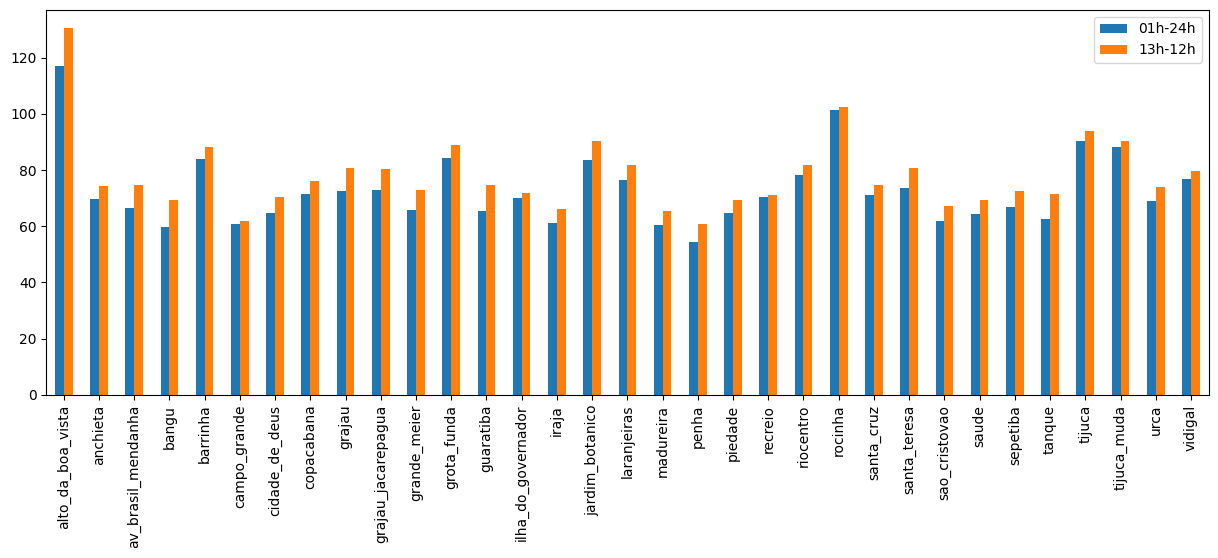

In [40]:
# Acrescentando identificadores de origem de dataframe (qual)
percentil_99_13_12.name = '13h-12h'
percentil_99_01_24.name = '01h-24h'

fig, ax = plt.subplots(1,1, figsize = (15,5))

df_percents = pd.concat([percentil_99_01_24, percentil_99_13_12], axis = 1)
df_percents.plot(kind = 'bar', ax = ax)

# Detectando eventos extremos
Eventos acima do percentil

In [61]:
# Ideia -> Quais são os eventos que ocorrem em mais de 6 estações simultaneamente?
# Ideia -> Destes, quais ultrapassaram os percentis-99 em todas as estações?
eventos_extremos = []

for ind, dados in df_eventos_estacoes.iterrows():
  evento, estacoes = dados[0], dados[1]
  df_acumulado_01_24_aux = (df_acumulado_01_24.loc[evento, estacoes])
  df_acumulado_13_12_aux = (df_acumulado_13_12.loc[evento, estacoes])
  # Interseção de estações (para garantir que nomes batem)
  estacoes_comuns = df_acumulado_01_24_aux.index.intersection(percentil_99_01_24.index)
  # Filtra ambos para essas estações
  p99_filtrado_24 = percentil_99_01_24[estacoes_comuns]
  p99_filtrado_13 = percentil_99_13_12[estacoes_comuns]
  # Verificando se os percentis foram ultrapassados
  resultado_24 = len(df_acumulado_01_24_aux[df_acumulado_01_24_aux > p99_filtrado_24])
  resultado_13 = len(df_acumulado_13_12_aux[df_acumulado_13_12_aux > p99_filtrado_13])
  # Se forem encontrados valores maiores do P99_24 ou do P99_13 -> evento extremo
  if resultado_24 == len(df_acumulado_01_24_aux) or resultado_13 == len(df_acumulado_13_12_aux):
    print(f'Evento {evento} ocorreu em todas as estações simultaneamente')
    eventos_extremos.append(evento)


Evento 1998-02-11 ocorreu em todas as estações simultaneamente
Evento 2001-12-23 ocorreu em todas as estações simultaneamente
Evento 2003-03-17 ocorreu em todas as estações simultaneamente
Evento 2007-10-24 ocorreu em todas as estações simultaneamente
Evento 2010-04-05 ocorreu em todas as estações simultaneamente
Evento 2019-04-08 ocorreu em todas as estações simultaneamente
Evento 2022-04-30 ocorreu em todas as estações simultaneamente
